<a href="https://colab.research.google.com/github/abhaydubey200/card_memo/blob/main/ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [5]:
df_price = pd.read_excel("Small Cardamom Auction Average Price 2014-2025..xlsx")
df_price.head()

,Date of Auction,Qty Sold (Kgs),Avg.Price (Rs./Kg)
0,2025-10-29,101810.3,2503.80
1,2025-10-29,21767.9,2467.68
2,2025-10-28,84888.1,2464.22
3,2025-10-28,90880.9,2479.12
4,2025-10-27,79737.1,2466.66


In [8]:
df_second = pd.read_html("data (32).xls")[0]
df_second.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...,Month-wise Actual Rainfall in Kerala (1901 to ...
1,(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter),(In Millimeter)
2,Year,Jan.,Feb.,Mar.,Apr.,May,Jun.,Jul.,Aug.,Sept.,Oct.,Nov.,Dec.,Annual
3,1901,28.70,44.70,51.60,159.90,174.70,824.60,743.00,357.50,197.70,266.90,350.80,48.40,3248.50
4,1902,6.70,2.60,57.30,83.90,134.50,390.90,1205.00,315.80,491.60,358.40,158.30,121.50,3326.50


In [27]:
print("Price Dataset Shape:", df_price.shape)
print("Second Dataset Shape:", df_second.shape)


print("\nPrice Columns:\n", df_price.columns)
print("\nSecond Dataset Columns:\n", df_second.columns)
# df_second.isnull().sum()

Price Dataset Shape: (5277, 3)
Second Dataset Shape: (128, 14)

Price Columns:
 Index(['Date', 'Qty Sold (Kgs)', 'Avg.Price (Rs./Kg)'], dtype='object')

Second Dataset Columns:
 Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'],
      dtype='object')


In [56]:
# -----------------------------
# 1️⃣ Ensure df_price has month & year
# -----------------------------
df_price['date'] = pd.to_datetime(df_price['date'], errors='coerce')  # just in case
df_price['year'] = df_price['date'].dt.year
df_price['month'] = df_price['date'].dt.month

# Quick check
print("df_price head:\n", df_price[['date', 'year', 'month']].head())

# -----------------------------
# 2️⃣ Ensure df_second_fixed has month & year
# -----------------------------
# Convert month names to numbers if needed
month_map = {
    'jan':1, 'january':1,
    'feb':2, 'february':2,
    'mar':3, 'march':3,
    'apr':4, 'april':4,
    'may':5,
    'jun':6, 'june':6,
    'jul':7, 'july':7,
    'aug':8, 'august':8,
    'sep':9, 'september':9,
    'oct':10, 'october':10,
    'nov':11, 'november':11,
    'dec':12, 'december':12
}

# Clean columns
df_second_fixed.columns = df_second_fixed.columns.str.strip().str.lower()

# Make sure month column exists
if 'month' in df_second_fixed.columns:
    df_second_fixed['month'] = df_second_fixed['month'].astype(str).str.strip().str.lower()
    df_second_fixed['month'] = df_second_fixed['month'].map(month_map)

# Create year column
if 'year' in df_second_fixed.columns:
    df_second_fixed['year'] = pd.to_numeric(df_second_fixed['year'], errors='coerce')

# Quick check
print("df_second_fixed head:\n", df_second_fixed[['year','month']].head())


df_price head:
            date  year  month
5276 2015-01-14  2015      1
5275 2015-01-14  2015      1
5273 2015-05-01  2015      5
5274 2015-05-01  2015      5
5271 2015-05-02  2015      5
df_second_fixed head:
    year  month
0  1901      1
1  1901      2
2  1901      3
3  1901      4
4  1901      5


In [57]:
# -----------------------------
# 1️⃣ Aggregate df_second_fixed monthly if needed
# -----------------------------
# For example, if df_second_fixed has multiple rows per month, take mean
df_second_monthly = (
    df_second_fixed
    .groupby(['year', 'month'], as_index=False)
    .agg({
        'rainfall': 'mean'  # adjust if more columns exist
    })
)

# -----------------------------
# 2️⃣ Merge datasets on year + month
# -----------------------------
df_merged = pd.merge(
    df_price,
    df_second_monthly,
    on=['year', 'month'],
    how='left'  # keep all df_price rows
)

# -----------------------------
# 3️⃣ Optional: set date as index
# -----------------------------
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged = df_merged.sort_values('date')
df_merged.set_index('date', inplace=True)

# -----------------------------
# 4️⃣ Validate merge
# -----------------------------
print("✅ Merge completed")
print(df_merged.head())
print("\nMissing values after merge:\n", df_merged.isna().sum())


✅ Merge completed
            qty sold (kgs)  avg.price (rs./kg)  year  month  month_num  \
date                                                                     
2015-01-14         76699.0              861.93  2015      1          1   
2015-01-14         76699.0              861.93  2015      1          1   
2015-05-01         10132.0              680.56  2015      5          5   
2015-05-01         20623.0              719.43  2015      5          5   
2015-05-02         27568.0              655.47  2015      5          5   

            rainfall  
date                  
2015-01-14       3.2  
2015-01-14       3.2  
2015-05-01     203.0  
2015-05-01     203.0  
2015-05-02     203.0  

Missing values after merge:
 qty sold (kgs)          0
avg.price (rs./kg)      0
year                    0
month                   0
month_num               0
rainfall              456
dtype: int64


In [58]:
df_merged.isnull().sum()

,0
qty sold (kgs),0
avg.price (rs./kg),0
year,0
month,0
month_num,0
rainfall,456


In [59]:
df_merged['rainfall'] = df_merged.groupby('month_num')['rainfall'].transform(lambda x: x.fillna(x.mean()))


In [60]:
df_merged['rainfall'] = df_merged['rainfall'].ffill()


In [61]:
df_merged.isna().sum()


,0
qty sold (kgs),0
avg.price (rs./kg),0
year,0
month,0
month_num,0
rainfall,0


In [62]:
# Fill missing rainfall first (recommended)
df_merged['rainfall'] = df_merged.groupby('month_num')['rainfall'].transform(lambda x: x.fillna(x.mean()))

# Optional: reset index if you want Date as a column
df_final = df_merged.reset_index()

# Save to CSV
df_final.to_csv('/content/final_merged_dataset.csv', index=False)

print("✅ Dataset saved successfully: final_merged_dataset.csv")


✅ Dataset saved successfully: final_merged_dataset.csv


In [65]:
df=pd.read_csv('final_merged_dataset.csv')
df.head()

,date,qty sold (kgs),avg.price (rs./kg),year,month,month_num,rainfall
0,2015-01-14,76699.0,861.93,2015,1,1,3.2
1,2015-01-14,76699.0,861.93,2015,1,1,3.2
2,2015-05-01,10132.0,680.56,2015,5,5,203.0
3,2015-05-01,20623.0,719.43,2015,5,5,203.0
4,2015-05-02,27568.0,655.47,2015,5,5,203.0


In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [67]:
# Use df_final from previous step
df = df_final.copy()

# Lag features (previous months)
df['price_lag1'] = df['avg.price (rs./kg)'].shift(1)
df['price_lag2'] = df['avg.price (rs./kg)'].shift(2)
df['quantity_lag1'] = df['qty sold (kgs)'].shift(1)
df['quantity_lag2'] = df['qty sold (kgs)'].shift(2)
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)

# Moving averages
df['price_ma3'] = df['avg.price (rs./kg)'].rolling(window=3).mean()
df['quantity_ma3'] = df['qty sold (kgs)'].rolling(window=3).mean()
df['rainfall_ma3'] = df['rainfall'].rolling(window=3).mean()

# Drop rows with NaN (first few rows)
df = df.dropna()


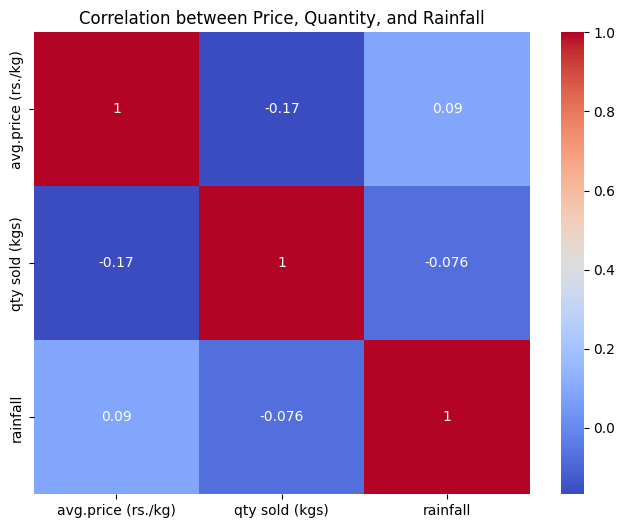

In [68]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['avg.price (rs./kg)', 'qty sold (kgs)', 'rainfall']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Price, Quantity, and Rainfall")
plt.show()


In [70]:
from sklearn.metrics import mean_squared_error

mse_price = mean_squared_error(y_test_price, pred_price)
rmse_price = np.sqrt(mse_price)

mse_quantity = mean_squared_error(y_test_quantity, pred_quantity)
rmse_quantity = np.sqrt(mse_quantity)

print("Price MAE:", mean_absolute_error(y_test_price, pred_price))
print("Price RMSE:", rmse_price)
print("Quantity MAE:", mean_absolute_error(y_test_quantity, pred_quantity))
print("Quantity RMSE:", rmse_quantity)


Price MAE: 28.81257431279611
Price RMSE: 38.540733459186725
Quantity MAE: 2841.133788151655
Quantity RMSE: 4402.645074813929


In [71]:
# Features and target
features = ['quantity_lag1','quantity_lag2','price_lag1','price_lag2','rainfall','rainfall_lag1','rainfall_lag2','price_ma3','quantity_ma3','rainfall_ma3']
target_price = 'avg.price (rs./kg)'
target_quantity = 'qty sold (kgs)'

# Train/test split (Time-series safe)
train_size = int(len(df)*0.8)
train = df[:train_size]
test = df[train_size:]

X_train = train[features]
y_train_price = train[target_price]
y_train_quantity = train[target_quantity]

X_test = test[features]
y_test_price = test[target_price]
y_test_quantity = test[target_quantity]

# Random Forest Regressor
rf_price = RandomForestRegressor(n_estimators=200, random_state=42)
rf_price.fit(X_train, y_train_price)

rf_quantity = RandomForestRegressor(n_estimators=200, random_state=42)
rf_quantity.fit(X_train, y_train_quantity)

# Predictions
pred_price = rf_price.predict(X_test)
pred_quantity = rf_quantity.predict(X_test)




In [73]:
import pandas as pd

# Ensure your 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as index if not already
df.set_index('date', inplace=True)

# Number of months you want to forecast
forecast_months = 24

# Get the last date in your dataset
last_date = df.index[-1]

# Generate future dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                             periods=forecast_months, freq='MS')

# Create future dataframe
future_df = pd.DataFrame({'date': future_dates})

print(future_df.head())


        date
0 2025-12-01
1 2026-01-01
2 2026-02-01
3 2026-03-01
4 2026-04-01


In [74]:
forecast_months = 24
last_row = df.iloc[-1].copy()
future = []

for i in range(forecast_months):
    X_pred = last_row[features].values.reshape(1,-1)

    price_next = rf_price.predict(X_pred)[0]
    quantity_next = rf_quantity.predict(X_pred)[0]

    # Estimate rainfall as monthly average (or use a seasonal trend)
    rainfall_next = last_row['rainfall_ma3']

    # Append prediction
    future.append([price_next, quantity_next, rainfall_next])

    # Update last_row for next iteration
    last_row['price_lag2'] = last_row['price_lag1']
    last_row['price_lag1'] = price_next
    last_row['quantity_lag2'] = last_row['quantity_lag1']
    last_row['quantity_lag1'] = quantity_next
    last_row['rainfall_lag2'] = last_row['rainfall_lag1']
    last_row['rainfall_lag1'] = rainfall_next
    last_row['price_ma3'] = np.mean([last_row['price_lag1'], last_row['price_lag2'], last_row['avg.price (rs./kg)']])
    last_row['quantity_ma3'] = np.mean([last_row['quantity_lag1'], last_row['quantity_lag2'], last_row['qty sold (kgs)']])
    last_row['rainfall_ma3'] = np.mean([last_row['rainfall_lag1'], last_row['rainfall_lag2'], last_row['rainfall']])

# Convert to DataFrame
future_df = pd.DataFrame(future, columns=['pred_price','pred_quantity','pred_rainfall'])

# Add Year & Month
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')
future_df['date'] = future_dates

future_df.set_index('date', inplace=True)
future_df.head()


,pred_price,pred_quantity,pred_rainfall
date,,,
2025-12-01,2481.13780,92663.8520,287.911137
2026-01-01,2479.06095,92921.4280,287.911137
2026-02-01,2481.33820,96510.7590,287.911137
2026-03-01,2479.70435,98152.5625,287.911137
2026-04-01,2481.33820,99866.2040,287.911137


In [77]:
future_df.to_excel('/content/forecast_24_months_random.xlsx')
print(" Forecast saved: forecast_24_months.csv")


 Forecast saved: forecast_24_months.csv


In [78]:
import pandas as pd
from prophet import Prophet

# Ensure your date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Prepare data for Prophet
# Prophet expects columns: ds (date) and y (value to predict)

# 1️⃣ Forecast Price
price_df = df[['date', 'avg.price (rs./kg)']].rename(columns={'date': 'ds', 'avg.price (rs./kg)': 'y'})

price_model = Prophet()
price_model.fit(price_df)

# Future dataframe for 24 months
future_price = price_model.make_future_dataframe(periods=24, freq='MS')

# Predict
forecast_price = price_model.predict(future_price)
print(forecast_price[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 2️⃣ Forecast Quantity
quantity_df = df[['date', 'qty sold (kgs)']].rename(columns={'date': 'ds', 'qty sold (kgs)': 'y'})

quantity_model = Prophet()
quantity_model.fit(quantity_df)

future_quantity = quantity_model.make_future_dataframe(periods=24, freq='MS')
forecast_quantity = quantity_model.predict(future_quantity)
print(forecast_quantity[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


KeyError: 'date'

In [79]:
print(df.columns)


Index(['qty sold (kgs)', 'avg.price (rs./kg)', 'year', 'month', 'month_num',
       'rainfall', 'price_lag1', 'price_lag2', 'quantity_lag1',
       'quantity_lag2', 'rainfall_lag1', 'rainfall_lag2', 'price_ma3',
       'quantity_ma3', 'rainfall_ma3'],
      dtype='object')


In [80]:
import pandas as pd

# Create a datetime column from year and month
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# For Price forecasting
price_df = df[['ds', 'avg.price (rs./kg)']].rename(columns={'avg.price (rs./kg)': 'y'})

# For Quantity forecasting
quantity_df = df[['ds', 'qty sold (kgs)']].rename(columns={'qty sold (kgs)': 'y'})


In [81]:
from prophet import Prophet

# Price model
price_model = Prophet()
price_model.fit(price_df)
future_price = price_model.make_future_dataframe(periods=24, freq='MS')  # next 2 years
forecast_price = price_model.predict(future_price)

# Quantity model
quantity_model = Prophet()
quantity_model.fit(quantity_df)
future_quantity = quantity_model.make_future_dataframe(periods=24, freq='MS')
forecast_quantity = quantity_model.predict(future_quantity)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
import pandas as pd
from prophet import Prophet

# -------------------------------
# 1️⃣ Prepare Data
# -------------------------------
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Price data
price_df = df[['ds', 'avg.price (rs./kg)']].rename(columns={'avg.price (rs./kg)': 'y'})

# Quantity data
quantity_df = df[['ds', 'qty sold (kgs)']].rename(columns={'qty sold (kgs)': 'y'})

# -------------------------------
# 2️⃣ Fit Prophet Models
# -------------------------------
# Price
price_model = Prophet()
price_model.fit(price_df)
future_price = price_model.make_future_dataframe(periods=24, freq='MS')  # next 2 years
forecast_price = price_model.predict(future_price)

# Quantity
quantity_model = Prophet()
quantity_model.fit(quantity_df)
future_quantity = quantity_model.make_future_dataframe(periods=24, freq='MS')
forecast_quantity = quantity_model.predict(future_quantity)

# -------------------------------
# 3️⃣ Combine Forecasts
# -------------------------------
final_forecast = pd.DataFrame({
    'ds': forecast_price['ds'],
    'predicted_price': forecast_price['yhat'],
    'predicted_quantity': forecast_quantity['yhat']
})

# -------------------------------
# 4️⃣ Save to CSV
# -------------------------------
final_forecast.to_excel('forecast_2_years_Prophet.xlsx', index=False)
print("Forecast saved as 'forecast_2_years.csv'")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecast saved as 'forecast_2_years.csv'


In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -------------------------------
# 1️⃣ Prepare Data
# -------------------------------
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Use 'avg.price (rs./kg)' and 'qty sold (kgs)'
price_data = df[['avg.price (rs./kg)']].values
quantity_data = df[['qty sold (kgs)']].values

# Scale data
scaler_price = MinMaxScaler(feature_range=(0,1))
price_scaled = scaler_price.fit_transform(price_data)

scaler_quantity = MinMaxScaler(feature_range=(0,1))
quantity_scaled = scaler_quantity.fit_transform(quantity_data)

# -------------------------------
# 2️⃣ Create sequences for LSTM
# -------------------------------
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 12  # use past 12 months to predict next month

# Price sequences
X_price, y_price = create_sequences(price_scaled, seq_length)
X_price = X_price.reshape((X_price.shape[0], X_price.shape[1], 1))

# Quantity sequences
X_quantity, y_quantity = create_sequences(quantity_scaled, seq_length)
X_quantity = X_quantity.reshape((X_quantity.shape[0], X_quantity.shape[1], 1))

# -------------------------------
# 3️⃣ Build LSTM model
# -------------------------------
def build_lstm():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length,1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train price model
model_price = build_lstm()
model_price.fit(X_price, y_price, epochs=50, batch_size=16, verbose=1)

# Train quantity model
model_quantity = build_lstm()
model_quantity.fit(X_quantity, y_quantity, epochs=50, batch_size=16, verbose=1)

# -------------------------------
# 4️⃣ Forecast next 24 months
# -------------------------------
def forecast_lstm(model, data_scaled, seq_length, steps, scaler):
    temp_input = data_scaled[-seq_length:].reshape(1, seq_length, 1)
    forecast = []
    for _ in range(steps):
        pred = model.predict(temp_input, verbose=0)[0][0]
        forecast.append(pred)
        temp_input = np.append(temp_input[:,1:,:], [[pred]], axis=1)
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1,1))
    return forecast

forecast_months = 24
pred_price = forecast_lstm(model_price, price_scaled, seq_length, forecast_months, scaler_price)
pred_quantity = forecast_lstm(model_quantity, quantity_scaled, seq_length, forecast_months, scaler_quantity)

# -------------------------------
# 5️⃣ Create forecast DataFrame
# -------------------------------
last_date = df['ds'].max()
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

forecast_df = pd.DataFrame({
    'ds': future_dates,
    'predicted_price': pred_price.flatten(),
    'predicted_quantity': pred_quantity.flatten()
})

# -------------------------------
# 6️⃣ Save to CSV
# -------------------------------
forecast_df.to_csv('forecast_lstm_2_years.csv', index=False)
print("Forecast saved as 'forecast_lstm_2_years.csv'")


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0084
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.8478e-04
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.1998e-04
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.3593e-04
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 4.5537e-04
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.3103e-04
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.0947e-04
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.7502e-04
Epoch 9/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.1196e-04
Epoch 10/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.5208e-04
Epoch 11/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.4049e-04
Epoch 12/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.3959e-04
Epoch 13/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.2662e-04
Epoch 14/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.2604e-04


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [86]:
def forecast_lstm(model, data_scaled, seq_length, steps, scaler):
    temp_input = data_scaled[-seq_length:].reshape(1, seq_length, 1)
    forecast = []

    for _ in range(steps):
        pred = model.predict(temp_input, verbose=0)[0][0]
        forecast.append(pred)
        # Reshape pred to (1,1,1) for concatenation
        pred_reshaped = np.array(pred).reshape(1, 1, 1)
        temp_input = np.concatenate((temp_input[:, 1:, :], pred_reshaped), axis=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1,1))
    return forecast


In [89]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -----------------------------
# 1️⃣ LOAD DATA
# -----------------------------
df = pd.read_csv("final_merged_dataset.csv")  # Replace with your merged dataset
df = df.sort_values('year').reset_index(drop=True)

# -----------------------------
# 2️⃣ SELECT COLUMNS & SCALERS
# -----------------------------
price_data = df['avg.price (rs./kg)'].values.reshape(-1, 1)
quantity_data = df['qty sold (kgs)'].values.reshape(-1, 1)

scaler_price = MinMaxScaler()
scaler_quantity = MinMaxScaler()
price_scaled = scaler_price.fit_transform(price_data)
quantity_scaled = scaler_quantity.fit_transform(quantity_data)

# -----------------------------
# 3️⃣ CREATE SEQUENCES
# -----------------------------
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 12
X_price, y_price = create_sequences(price_scaled, seq_length)
X_quantity, y_quantity = create_sequences(quantity_scaled, seq_length)

# -----------------------------
# 4️⃣ LSTM MODEL FUNCTION
# -----------------------------
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

model_price = build_lstm_model((seq_length, 1))
model_quantity = build_lstm_model((seq_length, 1))

# -----------------------------
# 5️⃣ TRAIN MODELS
# -----------------------------
model_price.fit(X_price, y_price, epochs=50, batch_size=32, verbose=1)
model_quantity.fit(X_quantity, y_quantity, epochs=50, batch_size=32, verbose=1)

# -----------------------------
# 6️⃣ FORECAST FUNCTION
# -----------------------------
def forecast_lstm(model, data_scaled, seq_length, steps, scaler):
    temp_input = data_scaled[-seq_length:].reshape(1, seq_length, 1)
    forecast = []

    for _ in range(steps):
        pred = model.predict(temp_input, verbose=0)[0][0]
        forecast.append(pred)
        pred_reshaped = np.array(pred).reshape(1, 1, 1)
        temp_input = np.concatenate((temp_input[:, 1:, :], pred_reshaped), axis=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1,1))
    return forecast

# -----------------------------
# 7️⃣ PREDICT NEXT 24 MONTHS
# -----------------------------
forecast_months = 24
pred_price = forecast_lstm(model_price, price_scaled, seq_length, forecast_months, scaler_price)
pred_quantity = forecast_lstm(model_quantity, quantity_scaled, seq_length, forecast_months, scaler_quantity)

# -----------------------------
# 8️⃣ CREATE FUTURE DATAFRAME
# -----------------------------
last_year = df['year'].iloc[-1]
last_month = df['month'].iloc[-1]
future_dates = pd.date_range(start=f"{last_year}-{last_month}-01", periods=forecast_months, freq='MS')

future_df = pd.DataFrame({
    'date': future_dates,
    'pred_price': pred_price.flatten(),
    'pred_quantity': pred_quantity.flatten()
})




Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0333
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 15/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

In [90]:
# -----------------------------
# 9️⃣ SAVE TO CSV
# -----------------------------
future_df.to_csv("lstm_forecast_24_months.xlsx", index=False)
print("Forecast saved as 'lstm_forecast_24_months.csv'")

Forecast saved as 'lstm_forecast_24_months.csv'


In [91]:
# -----------------------------
# 9️⃣ SAVE TO EXCEL
# -----------------------------
future_df.to_excel("lstm_forecast_24_months.xlsx", index=False)
print("Forecast saved as 'lstm_forecast_24_months.xlsx'")


Forecast saved as 'lstm_forecast_24_months.xlsx'


In [5]:
import pandas as pd
df1=pd.read_excel('Sales Order Sample Live Data.xlsx')
df1.head()

,MFD_ORDER_PK,ORDER_ID,SOURCE,ORDER_DATE,ORDER_TIME,ORDERSTATE,ORDERTYPE,OUTLET_ID,OUTLET_NAME,OUTLET_ERP_ID,...,REJECTED_ORDER_COMMENT,TIME_SPENT_AT_OUTLET,ASSET_SERIAL_NUMBER,EX_FACT_UNIT_PRICE,EX_FACT_AMOUNT,ASSET_OWNED,WAREHOUSE_GSTIN,HI_PO_OUTLET,BUSS_CODE,VERIFIED_OUTLET
0,237065541,19059058,APP,2025-12-01,08:45:57,ACCEPTED,NORMAL,1161875,SIDDESHWAR STORES,NaN,...,NaN,00:00:09,NaN,NaN,0,NaN,29ABUPJ4693D1Z3,NaN,CONF,OUTLET_VERIFIED
1,237065542,19059058,APP,2025-12-01,08:45:57,ACCEPTED,NORMAL,1161875,SIDDESHWAR STORES,NaN,...,NaN,00:00:09,NaN,NaN,0,NaN,29ABUPJ4693D1Z3,NaN,CONF,OUTLET_VERIFIED
2,237065543,19059059,APP,2025-12-01,08:45:55,ACCEPTED,NORMAL,1284485,SURAT GANRAL STORE,NaN,...,NaN,00:00:12,NaN,NaN,0,NaN,27HVRPS9644P1ZZ,NaN,CONF,OUTLET_VERIFIED
3,237065544,19059059,APP,2025-12-01,08:45:55,ACCEPTED,NORMAL,1284485,SURAT GANRAL STORE,NaN,...,NaN,00:00:12,NaN,NaN,0,NaN,27HVRPS9644P1ZZ,NaN,CONF,OUTLET_VERIFIED
4,237065545,19059060,APP,2025-12-01,08:46:13,ACCEPTED,NORMAL,1284542,AAISA GANRAL STORE,NaN,...,NaN,00:00:23,NaN,NaN,0,NaN,27HVRPS9644P1ZZ,NaN,CONF,OUTLET_VERIFIED


In [7]:
df1.columns

Index(['MFD_ORDER_PK', 'ORDER_ID', 'SOURCE', 'ORDER_DATE', 'ORDER_TIME',
       'ORDERSTATE', 'ORDERTYPE', 'OUTLET_ID', 'OUTLET_NAME', 'OUTLET_ERP_ID',
       'TYPE', 'OUTLET_CATEGORY', 'OUTLET_CREATED_DATE', 'CITY', 'PHONE_NO',
       'MOBILE_NO', 'BEAT_ID', 'BEAT_NAME', 'AREA_ID', 'AREA', 'WAREHOUSE_ID',
       'WAREHOUSE', 'WAREHOUSE_CATEGORY', 'WAREHOUSE_ERP_CODE', 'WD',
       'WD_NAME', 'ZONE_ID', 'ZONE', 'SUBZONE_ID', 'SUBZONE', 'STATE',
       'WAREHOUSE_CITY', 'BUSINESS_UNIT', 'USER_ID', 'EMPLOYEE_ID', 'USER_NM',
       'USERNAME', 'DESIGNATION_REPORT_TO', 'DESIGNATION_MNGR_REPORTING_TO',
       'DESIGNATION', 'REPORTING_TO_USER_ID', 'REPORTING_TO',
       'MANAGER_USER_ID_REPORTING_TO', 'MANAGER_REPORTING_TO', 'SKU_ID',
       'SKU_PLACED', 'CATEGORY', 'SUBCATEGORIES', 'BRAND', 'SKU_CODE',
       'TOTAL_QUANTITY', 'TOTAL_QUANTITY_IN_CASES', 'TOTAL_QUANTITY_IN_PIECES',
       'TOTAL_QUANTITY_IN_KG', 'SCHEME_DISCOUNT', 'DISCOUNT_AMOUNT',
       'UNITPRICE', 'AMOUNT', 'REJECTED_